**Student ID's:** Sumeet Kumar - s222615086 | Akash Verma - s223669999 | HO-SE Kim - s224564517

**Student Name's:** Sumeet Kumar | Akash Verma | HO-SE Kim

**Workshop / Lab Session Time:** Tuesday - 11:00 AM

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col, dayofweek, countDistinct, month
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics.pairwise import euclidean_distances
from mlxtend.frequent_patterns import apriori, association_rules
import warnings

Question 1.1

In [32]:
# Start or get the existing Spark session
spark = SparkSession.builder.appName("DataWrangling").getOrCreate()

# Configure Spark session to show more characters in each column and prevent output truncation
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark.conf.set("spark.sql.repl.eagerEval.truncate", 100)

# Load the transaction data from the CSV file
transaction = spark.read.csv('transactionrecord.csv', header=True, inferSchema=True)

# 1.1.1 Replace 'NA' values with '-1' in the CustomerNo column as part of data cleaning
transaction = transaction.withColumn("CustomerNo", regexp_replace("CustomerNo", "NA", "-1"))

# 1.1.2 Remove non-alphabet characters from the productName column and store the cleaned names in a new column called productName_process
transaction = transaction.withColumn("productName_process", regexp_replace("productName", "[^a-zA-Z ]", ""))

# 1.1.2 Display the first 5 rows of the DataFrame to verify the modifications
transaction.select("CustomerNo", "productName", "productName_process").show(5, truncate=False)


+----------+-----------------------------------+-----------------------------------+
|CustomerNo|productName                        |productName_process                |
+----------+-----------------------------------+-----------------------------------+
|17490     |Set Of 2 Wooden Market Crates      |Set Of  Wooden Market Crates       |
|13069     |Christmas Star Wish List Chalkboard|Christmas Star Wish List Chalkboard|
|13069     |Storage Tin Vintage Leaf           |Storage Tin Vintage Leaf           |
|13069     |Tree T-Light Holder Willie Winkie  |Tree TLight Holder Willie Winkie   |
|13069     |Set Of 4 Knick Knack Tins Poppies  |Set Of  Knick Knack Tins Poppies   |
+----------+-----------------------------------+-----------------------------------+
only showing top 5 rows



Question 1.2

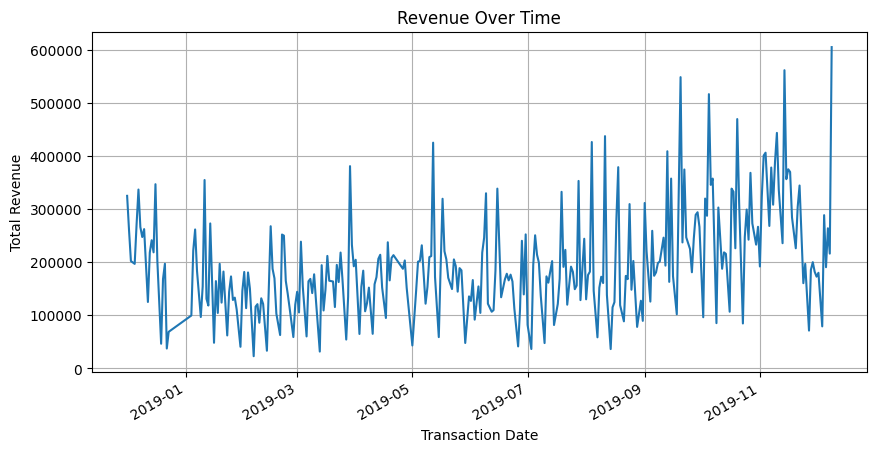

In [34]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 1.2.1 Calculate revenue by multiplying 'price' and 'Quantity', ensuring the result is stored as a float
transaction = transaction.withColumn("Revenue", (col("price") * col("Quantity")).cast("float"))

# 1.2.2 Convert the Spark DataFrame to a Pandas DataFrame for advanced processing and rename relevant columns
df = transaction.toPandas()
df.rename(columns={'Revenue': 'revenue', 'Date': 'transaction_date'}, inplace=True)

# Convert the 'transaction_date' column to datetime format for accurate time series analysis
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# 1.2.3 Plot the total revenue over time to identify trends and insights
plt.figure(figsize=(10, 5))
df.groupby('transaction_date')['revenue'].sum().plot(kind='line', title='Revenue Over Time')
plt.xlabel('Transaction Date')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.show()


The revenue shows significant volatility over time with noticeable peaks and troughs. This could indicate variability in sales due to factors like seasonal demand, promotions, or changes in consumer behavior

The sharp peaks suggest that there are specific days or periods with exceptionally high sales. Identifying these can help in planning better inventory and marketing strategies.

The valleys, especially those that dip significantly, might indicate periods of low activity where consumer engagement could be improved. Analyzing what contributes to these dips—be it inventory issues, lesser marketing efforts, or external economic factors—could provide actionable insights.

A moving average or trend line overlaid on this plot could help in understanding the underlying trend beyond the weekly or monthly fluctuations. This can be particularly useful for strategic planning and forecasting.

Question 1.3

In [36]:
# Ensure 'Date' column is cast to date type to facilitate extraction of the day of the week
transaction = transaction.withColumn("Date", transaction["Date"].cast("date"))

# Add a 'DayOfWeek' column representing the day of the week as an integer (Sunday=1, Saturday=7)
transaction = transaction.withColumn("DayOfWeek", dayofweek(transaction["Date"]))

# 1.3.1 Calculate the average revenue per day of the week to identify which day typically sees the highest sales
avg_revenue_by_day = transaction.groupBy("DayOfWeek").avg("Revenue").orderBy("avg(Revenue)", ascending=False)
avg_revenue_by_day.show(1)  # Display the day with the highest average revenue

# Capture the day of the week with the highest average revenue for further analysis
that_workday = avg_revenue_by_day.first()["DayOfWeek"]

# 1.3.2 Identify the top-selling product by revenue on 'that_workday'
top_products_revenue = transaction.filter(transaction["DayOfWeek"] == that_workday).groupBy("productName_process").sum("Revenue").orderBy("sum(Revenue)", ascending=False)
top_products_revenue.show(1)  # Display the top revenue product on 'that_workday'

# Identify the top-selling product by quantity on 'that_workday'
top_products_quantity = transaction.filter(transaction["DayOfWeek"] == that_workday).groupBy("productName_process").sum("Quantity").orderBy("sum(Quantity)", ascending=False)
top_products_quantity.show(1)  # Display the top product by quantity on 'that_workday'

# 1.3.3 Display the top 5 products by overall revenue across all days
top_5_revenue_all_time = transaction.groupBy("productName_process").sum("Revenue").orderBy("sum(Revenue)", ascending=False)
top_5_revenue_all_time.show(5)  # Display the top 5 products by total revenue

# Display the top 5 products by overall quantity across all days
top_5_quantity_all_time = transaction.groupBy("productName_process").sum("Quantity").orderBy("sum(Quantity)", ascending=False)
top_5_quantity_all_time.show(5)  # Display the top 5 products by total quantity


+---------+----------------+
|DayOfWeek|    avg(Revenue)|
+---------+----------------+
|     NULL|112.389343667037|
+---------+----------------+

+-------------------+------------+
|productName_process|sum(Revenue)|
+-------------------+------------+
+-------------------+------------+

+-------------------+-------------+
|productName_process|sum(Quantity)|
+-------------------+-------------+
+-------------------+-------------+

+--------------------+------------------+
| productName_process|      sum(Revenue)|
+--------------------+------------------+
|      Popcorn Holder| 583286.5114817619|
|World War  Glider...| 557170.4306898117|
|Paper Craft Littl...|       501359.0625|
|Cream Hanging Hea...| 451401.7014603615|
|Assorted Colour B...|420743.69341278076|
+--------------------+------------------+
only showing top 5 rows

+--------------------+-------------+
| productName_process|sum(Quantity)|
+--------------------+-------------+
|      Popcorn Holder|        56450|
|World War  Glide

Question 1.4

In [37]:
# 1.4.1 Aggregate revenue by country to identify which country generates the highest total revenue
revenue_by_country = transaction.groupBy("Country").sum("Revenue").withColumnRenamed("sum(Revenue)", "TotalRevenue")

# Identify the country with the highest revenue
top_country = revenue_by_country.orderBy("TotalRevenue", ascending=False).first()

# Display the country with the highest revenue and the total amount
print(f"Country with the highest revenue: {top_country['Country']} with total revenue: {top_country['TotalRevenue']}")

# 1.4.2 Filter the transaction data for the country with the highest revenue and aggregate revenue by month
transaction_top_country = transaction.filter(transaction["Country"] == top_country["Country"])
revenue_by_month = transaction_top_country.groupBy(month("Date").alias("Month")).sum("Revenue").withColumnRenamed("sum(Revenue)", "MonthlyRevenue")

# Identify the month with the highest revenue within the top country
top_month = revenue_by_month.orderBy("MonthlyRevenue", ascending=False).first()

# Display the month with the highest revenue within the top country
print(f"In {top_country['Country']}, the month with the highest revenue is: Month {top_month['Month']} with revenue: {top_month['MonthlyRevenue']}")


Country with the highest revenue: United Kingdom with total revenue: 49994030.344613075
In United Kingdom, the month with the highest revenue is: Month None with revenue: 49994030.344613075


Question 1.5

In [38]:
# 1.5.1 Determine the most frequent shopper by counting unique transaction numbers per customer
customer_frequency = transaction.groupBy("CustomerNo").agg(countDistinct("TransactionNo").alias("ShoppingTrips"))

# Identify the customer with the highest number of distinct shopping trips
most_frequent_customer = customer_frequency.orderBy("ShoppingTrips", ascending=False).first()

# Display the customer number and the number of shopping trips for the most frequent shopper
print(f"Most frequent shopper: CustomerNo {most_frequent_customer['CustomerNo']} with {most_frequent_customer['ShoppingTrips']} shopping trips.")

# 1.5.2 Analyze the buying preferences of the most frequent shopper by examining the products they purchase most
# Filter transactions to include only those with positive quantity (indicating a purchase was made)
product_preferences = transaction.filter((transaction["CustomerNo"] == most_frequent_customer["CustomerNo"]) & (transaction["Quantity"] > 0))

# Group by product name and sum the quantities to identify top products by purchase volume
top_products = product_preferences.groupBy("productName_process").sum("Quantity").orderBy("sum(Quantity)", ascending=False)

# Display the top 5 products purchased by the most frequent shopper
print("Top products purchased by the most frequent shopper:")
top_products.show(5)  # Shows the top 5 most purchased products


Most frequent shopper: CustomerNo 14911 with 241 shopping trips.
Top products purchased by the most frequent shopper:
+--------------------+-------------+
| productName_process|sum(Quantity)|
+--------------------+-------------+
| Cake Cases Vinta...|         1440|
|Set Of  Vintage C...|         1140|
| Doilies Vintage ...|         1068|
|      Popcorn Holder|          928|
|  Vintage Snap Cards|          804|
+--------------------+-------------+
only showing top 5 rows



Question 1.6

In [39]:
# 1.6.1 Filter transactions to include only those with a positive quantity (valid purchases)
df_filtered = df[df['Quantity'] > 0]

# Group by TransactionNo and aggregate product categories and product names into lists
df_agg = df_filtered.groupby('TransactionNo').agg({
    'Product_category': lambda x: list(x),
    'productName_process': lambda x: list(x)
}).reset_index()

# Display the first 5 rows to verify the aggregation
print(df_agg.head())

# 1.6.2 Define a function to remove adjacent duplicates from a list
def remove_adjacent_duplicates(lst):
    return [v for i, v in enumerate(lst) if i == 0 or v != lst[i - 1]]

# Apply the function to remove adjacent duplicates in the Product_category column
df_agg['Product_category'] = df_agg['Product_category'].apply(remove_adjacent_duplicates)

# Save the processed DataFrame as 'df_1' and display the top 10 rows for verification
df_1 = df_agg.copy()
print(df_1.head(10))


  TransactionNo                                   Product_category  \
0        536365                [0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca]   
1        536366                                         [0ca, 0ca]   
2        536367  [0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, ...   
3        536368                               [0ca, 0ca, 0ca, 0ca]   
4        536369                                              [0ca]   

                                 productName_process  
0  [Cream Hanging Heart TLight Holder, White Moro...  
1  [Hand Warmer Union Jack, Hand Warmer Red Retro...  
2  [Assorted Colour Bird Ornament, Poppys Playhou...  
3  [Jam Making Set With Jars, Red Coat Rack Paris...  
4                         [Bath Building Block Word]  
  TransactionNo Product_category  \
0        536365            [0ca]   
1        536366            [0ca]   
2        536367            [0ca]   
3        536368            [0ca]   
4        536369            [0ca]   
5        536370            [0ca] 

Question 1.7

In [40]:
# 1.7.1 Add a new column 'prod_len' to df_1 that represents the length of the Product_category list for each transaction
df_1['prod_len'] = df_1['Product_category'].apply(len)

# Display the first 5 rows of df_1 to verify the addition of the 'prod_len' column
print(df_1.head(5))

# 1.7.2 Define a function to process the data by creating a 'path' column and filtering based on product category list length
def data_processing(df, maxlength=3, minlength=1):
    # Create a 'path' column by joining the product categories with 'start' and 'conversion' as the endpoints
    df['path'] = df['Product_category'].apply(lambda x: ' > '.join(['start'] + x + ['conversion']))
    
    # Filter the DataFrame based on the length of the product category list, keeping rows within the specified range
    df_2 = df[(df['prod_len'] <= maxlength) & (df['prod_len'] >= minlength)]
    
    return df_2

# Apply the data_processing function to df_1 with maxlength=5 and minlength=2
df_2 = data_processing(df_1, maxlength=5, minlength=2)

# Display the top 10 rows of df_2 to verify the results
print(df_2.head(10))


  TransactionNo Product_category  \
0        536365            [0ca]   
1        536366            [0ca]   
2        536367            [0ca]   
3        536368            [0ca]   
4        536369            [0ca]   

                                 productName_process  prod_len  
0  [Cream Hanging Heart TLight Holder, White Moro...         1  
1  [Hand Warmer Union Jack, Hand Warmer Red Retro...         1  
2  [Assorted Colour Bird Ornament, Poppys Playhou...         1  
3  [Jam Making Set With Jars, Red Coat Rack Paris...         1  
4                         [Bath Building Block Word]         1  
   TransactionNo           Product_category  \
13        536378            [0ca, 1ca, 0ca]   
27        536395            [0ca, 1ca, 0ca]   
36        536404  [0ca, 1ca, 0ca, 4ca, 0ca]   
40        536408            [0ca, 1ca, 0ca]   
42        536412            [0ca, 4ca, 0ca]   
43        536415            [0ca, 1ca, 0ca]   
52        536464            [0ca, 1ca, 0ca]   
72        536532 

Question 1.8

In [41]:
# 1.8.1 - 1.8.3 Count occurrences of specific patterns in the 'path' column

# Count the number of transactions that end with the pattern ' > 0ca > conversion'
pattern_ends = df_2['path'].str.endswith(' > 0ca > conversion').sum()

# Count occurrences of the pattern '0ca > 1ca' within the 'path' column across all transactions
pattern_contains = df_2['path'].str.count('0ca > 1ca').sum()

# Print the results for the specific patterns
print(f"Transactions ending with ' > 0ca > conversion': {pattern_ends}")
print(f"Occurrences of '0ca > 1ca' in the dataset: {pattern_contains}")

# 1.8.4 Calculate the ratio for the occurrences of specific patterns

# Count the total occurrences of the pattern ' > 0ca > ' within the 'path' column
total_occurrences = df_2['path'].str.count(' > 0ca > ').sum()

# Calculate the ratio by dividing the pattern occurrences by the total occurrences
ratio_sum = pattern_contains / total_occurrences

# Print the final calculated ratio sum
print(f"Final ratio sum: {ratio_sum}")


Transactions ending with ' > 0ca > conversion': 3056
Occurrences of '0ca > 1ca' in the dataset: 1222
Final ratio sum: 0.17567567567567569


Question 1.9

In [42]:
# Task 1.9.1: Filter and pivot the dataframe to create a transaction-level product dataframe
top_100_products = df.groupby('productName_process')['Quantity'].sum().nlargest(100).index
df_filtered = df[df['productName_process'].isin(top_100_products) & (df['Quantity'] > 0)]
transaction_df = df_filtered.pivot_table(index='TransactionNo', columns='productName_process', values='Quantity', fill_value=0)
print("Transaction-Level Product DataFrame:")
print(transaction_df.head(5))

# Task 1.9.2 - 1.9.4: Apply the Apriori algorithm and generate association rules

# Convert the DataFrame to boolean (True/False) using the recommended approach
transaction_df_bool = transaction_df > 0
frequent_itemsets = apriori(transaction_df_bool.astype('bool'), min_support=0.015, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
print("\nAssociation Rules with Minimum Support of 1.5% and Lift > 1.0:")
print(rules.head())

# Task 1.9.3: Apply the Apriori algorithm to identify items with support >= 1.0% and lift > 10

# Apply the Apriori algorithm to find frequent itemsets with min_support=1.0%
frequent_itemsets_low_support = apriori(transaction_df_bool.astype('bool'), min_support=0.01, use_colnames=True)
rules_high_lift = association_rules(frequent_itemsets_low_support, metric="lift", min_threshold=10)
print("\nAssociation Rules with Support >= 1.0% and Lift > 10:")
print(rules_high_lift.head())

# Task 1.9.4: Explore three more examples with different support, confidence, and lift measurements

# Example 1: High Confidence
rules_high_conf = association_rules(frequent_itemsets_low_support, metric="confidence", min_threshold=0.8)
print("\nHigh Confidence Rules (Confidence >= 0.8):")
print(rules_high_conf.head())

# Example 2: High Lift
rules_very_high_lift = association_rules(frequent_itemsets_low_support, metric="lift", min_threshold=5.0)
print("\nHigh Lift Rules (Lift >= 5.0):")
print(rules_very_high_lift.head())

# Example 3: Lower Support
rules_low_support = association_rules(frequent_itemsets_low_support, metric="lift", min_threshold=1.0)
print("\nLow Support Rules (Support >= 1.0%):")
print(rules_low_support.head())


Transaction-Level Product DataFrame:
productName_process   Cake Cases Vintage Christmas   Ribbons Rustic Charm  \
TransactionNo                                                               
536365                                         0.0                    0.0   
536367                                         0.0                    0.0   
536370                                         0.0                    0.0   
536371                                         0.0                    0.0   
536373                                         0.0                    0.0   

productName_process   Sweetheart Fairy Cake Cases   Teatime Fairy Cake Cases  \
TransactionNo                                                                  
536365                                        0.0                        0.0   
536367                                        0.0                        0.0   
536370                                        0.0                        0.0   
536371                 

Question 1.10

In [19]:


# Task 1.10.1: Create the customer-product dataframe

# Filter out transactions with negative quantities
df_filtered = df[df['Quantity'] > 0]

# Identify the top 100 products by quantity
top_100_products = df_filtered.groupby('productName_process')['Quantity'].sum().nlargest(100).index

# Filter the dataframe to keep only the top 100 products
df_filtered = df_filtered[df_filtered['productName_process'].isin(top_100_products)]

# Create the customer-product dataframe
customer_product_df = df_filtered.pivot_table(index='CustomerNo',
                                              columns='productName_process',
                                              values='Quantity',
                                              aggfunc='sum',
                                              fill_value=0)

# Display the first few rows to verify the DataFrame
print("Customer-Product DataFrame:")
print(customer_product_df.head())

# Task 1.10.2: Calculate pairwise Euclidean distance

# Calculate pairwise Euclidean distance between customers
distances = euclidean_distances(customer_product_df)

# Convert the distance matrix to a DataFrame for easier interpretation
distance_df = pd.DataFrame(distances, index=customer_product_df.index, columns=customer_product_df.index)

# Display the distance DataFrame
print("\nPairwise Euclidean Distance between Customers:")
print(distance_df.head())

# Task 1.10.3: Find the top 3 most similar customers

def find_top_similar_customers(customer_no, distance_df):
    if customer_no in distance_df.index:
        customer_index = distance_df.index.get_loc(customer_no)
        similar_customers = distance_df.iloc[customer_index].argsort()[1:4]  # Exclude the customer themselves
        similar_customers_indices = distance_df.index[similar_customers]
        return similar_customers_indices.tolist()
    else:
        return None

# Find top 3 similar customers for CustomerNo 13069 and 17490
similar_customers_13069 = find_top_similar_customers('13069', distance_df)
similar_customers_17490 = find_top_similar_customers('17490', distance_df)

print(f"\nTop 3 similar customers to 13069: {similar_customers_13069}")
print(f"Top 3 similar customers to 17490: {similar_customers_17490}")

# Task 1.10.4: Product recommendations for CustomerNo 13069

target_customer = '13069'

if target_customer in customer_product_df.index:
    customer_index = customer_product_df.index.get_loc(target_customer)

    # Get the indices of the most similar customers
    similar_customers = distance_df.iloc[customer_index].argsort()[1:4]  # Exclude the customer themselves
    similar_customers_indices = customer_product_df.index[similar_customers]

    # Products purchased by similar customers but not by target customer
    target_customer_products = customer_product_df.loc[target_customer]
    similar_customers_products = customer_product_df.loc[similar_customers_indices].mean()

    # Filter to products the target customer hasn't purchased
    recommendations = similar_customers_products[(similar_customers_products > 0) & (target_customer_products == 0)]
    recommendations = recommendations.sort_values(ascending=False)

    print(f"\nProduct recommendations for CustomerNo {target_customer}:")
    print(recommendations)
else:
    print(f"CustomerNo {target_customer} does not exist in the DataFrame")


Customer-Product DataFrame:
productName_process   Cake Cases Vintage Christmas   Ribbons Rustic Charm  \
CustomerNo                                                                  
12004                                            0                      0   
12008                                            0                      1   
12025                                            0                      0   
12026                                            1                      1   
12031                                            0                      0   

productName_process   Sweetheart Fairy Cake Cases   Teatime Fairy Cake Cases  \
CustomerNo                                                                     
12004                                           0                          0   
12008                                           0                          0   
12025                                           0                          0   
12026                           

# Part II Sales Prediction

### Question 2.1

<Figure size 1200x800 with 0 Axes>

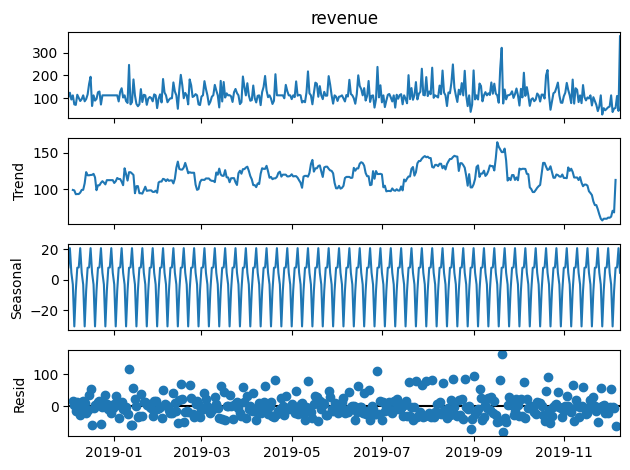

In [43]:
# Ensure the 'transaction_date' column is in datetime format
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Set 'transaction_date' as the index of the DataFrame
df.set_index('transaction_date', inplace=True)

# Calculate the mean revenue across all available data
mean_revenue = df['revenue'].mean()

# Resample the revenue data to a daily frequency, filling any missing dates with the calculated mean revenue
daily_revenue = df['revenue'].resample('D').mean().fillna(mean_revenue)

# Decompose the time series using an additive model to identify trend, seasonal, and residual components
decomposition = seasonal_decompose(daily_revenue, model='additive')

# Plot the decomposed components: observed, trend, seasonal, and residual
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()


### Question 2.2

In [44]:
# Suppress specific warnings that might occur during ARIMA model fitting
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found.")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge.")

# Assume 'daily_revenue' has already been prepared from the previous task

# Split the time series data into training and testing sets
train_data = daily_revenue[:'2019-11-01']
test_data = daily_revenue['2019-11-01':]

# Initialize variables to store the best model, its parameters, and the lowest MAE
best_mae = float('inf')  # Start with infinity as the benchmark for MAE
best_order = None  # Placeholder for the best (p, d, q) combination
best_model = None  # Placeholder for the best ARIMA model

# Grid search across different combinations of (p, d, q) parameters
for p in range(3):
    for d in range(3):
        for q in range(3):
            try:
                # Define and fit the ARIMA model with the current (p, d, q) parameters
                model = ARIMA(train_data, order=(p, d, q))
                model_fit = model.fit()
                
                # Forecast the test set using the fitted model
                predictions = model_fit.forecast(steps=len(test_data))
                
                # Calculate the Mean Absolute Error (MAE) between the actual test set and the predictions
                mae = mean_absolute_error(test_data, predictions)
                
                # Update the best model if the current MAE is lower than the best recorded MAE
                if mae < best_mae:
                    best_mae = mae
                    best_order = (p, d, q)
                    best_model = model_fit
                    
            except Exception as e:
                # Print out the exception message for debugging purposes
                print(f"An error occurred for ARIMA({p},{d},{q}): {e}")
                continue

# Output the best ARIMA model parameters and its corresponding MAE
print(f"Best ARIMA order: {best_order} with MAE: {best_mae}")


Best ARIMA order: (2, 2, 1) with MAE: 37.524140126255155


### Question 2.3

### Exploring Deep Learning Time Series Forecasting Methods

Time series forecasting is a critical aspect of data science, and deep learning models have shown great promise in capturing complex patterns within time series data. Below, I will explore various deep learning methods suitable for time series forecasting, along with the necessary data wrangling and modeling steps. The discussion will cover Recurrent Neural Networks (RNNs), Convolutional Neural Networks (CNNs), Transformer models, and hybrid approaches like CNN-LSTM.

### Deep Learning Methods for Time Series Forecasting

1. **Recurrent Neural Networks (RNNs)**:
   - **LSTM (Long Short-Term Memory)**: LSTMs are widely used for time series forecasting due to their ability to capture long-term dependencies in sequential data. They are particularly useful when the data exhibits temporal dependencies that span long periods.
   - **GRU (Gated Recurrent Units)**: GRUs are a simplified version of LSTMs, offering similar performance but with fewer parameters, making them faster to train.

2. **Convolutional Neural Networks (CNNs)**:
   - **Temporal Convolutional Networks (TCN)**: CNNs, and specifically TCNs, can be used to model time series data by capturing local temporal patterns through convolutional layers. They are effective when the data has short-term dependencies.

3. **Transformer Models**:
   - **Transformers**: Originally developed for natural language processing, transformers have been adapted for time series forecasting. They use self-attention mechanisms to capture long-range dependencies, making them suitable for complex time series data.

4. **Hybrid Models**:
   - **CNN-LSTM**: This hybrid model combines CNNs and LSTMs to capture both short-term and long-term dependencies in the data. CNN layers extract local features, while LSTM layers capture temporal dynamics.

5. **Seq2Seq Models**:
   - **Sequence-to-Sequence (Seq2Seq) Models**: These models are used for forecasting tasks where the input and output sequences have different lengths, such as multi-step forecasting.

### Data Wrangling and Modeling Steps

#### 1. Data Preparation

**a. Data Collection**:
   - Aggregate time series data at the appropriate frequency (e.g., daily, hourly). Ensure data is consistent and spans the necessary time periods.

**b. Data Cleaning**:
   - Handle missing values by imputing or interpolating, ensuring no gaps in the time series.
   - Identify and remove outliers that may skew the model training.

**c. Feature Engineering**:
   - **Lag Features**: Create lagged versions of the target variable (e.g., revenue) to capture temporal dependencies.
   - **Date/Time Features**: Extract features like day of the week, month, quarter, and holidays, which can help the model learn seasonal patterns.
   - **Rolling/Aggregated Features**: Compute rolling means, sums, or standard deviations over various windows to capture trends and volatility.

**d. Normalization/Standardization**:
   - Normalize or standardize the data to ensure it is within a suitable range for the model. This is particularly important for models like LSTM and GRU.

#### 2. Train-Test Split

**a. Temporal Split**:
   - Split the data into training and testing sets based on time, ensuring the model is only trained on past data and evaluated on future data.

**b. Validation Split**:
   - Further split the training set into training and validation subsets to tune hyperparameters and prevent overfitting.

#### 3. Model Selection and Configuration

**a. Choose the Model**:
   - Select a deep learning model based on the nature of the data:
     - **LSTM/GRU**: For data with strong temporal dependencies.
     - **CNN/TCN**: For data with clear local patterns.
     - **Transformers**: For complex data with long-range dependencies.

**b. Define the Architecture**:
   - **Input Layer**: Define the input shape based on the number of lag features and other predictors.
   - **Hidden Layers**: Add LSTM/GRU layers, CNN layers, or Transformer blocks depending on the model.
   - **Dropout Layers**: Use dropout to prevent overfitting by randomly setting some layer outputs to zero during training.
   - **Output Layer**: Configure the output layer based on whether the task is single-step or multi-step forecasting.

**c. Compile the Model**:
   - Choose an optimizer (e.g., Adam), loss function (e.g., Mean Squared Error), and evaluation metrics (e.g., MAE) that suit the forecasting task.

**d. Train the Model**:
   - Fit the model to the training data, using the validation set to monitor performance.
   - Employ techniques like early stopping to prevent overfitting if the validation performance deteriorates.

**e. Hyperparameter Tuning**:
   - Use grid search or random search to find the best combination of hyperparameters, such as the number of layers, units per layer, learning rate, and dropout rate.

#### 4. Model Evaluation and Interpretation

**a. Evaluate the Model**:
   - Test the model on the unseen test set using metrics like Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).
   - Generate forecasts and compare them with actual values to assess accuracy.

**b. Interpret Results**:
   - Analyze the model’s residuals and error metrics to understand where the model performs well and where it struggles.
   - Plot time series predictions against actual data to visually inspect forecast accuracy.

**c. Compare with Baseline Models**:
   - Compare the performance of the deep learning model with traditional models like ARIMA or Prophet to assess the added value of using deep learning.

#### 5. Model Deployment

**a. Export the Model**:
   - Save the trained model in a format that can be deployed (e.g., HDF5 for Keras models).

**b. Deploy the Model**:
   - Deploy the model to a production environment where it can generate real-time forecasts.

**c. Monitor the Model**:
   - Continuously monitor the model’s performance over time. Retrain the model periodically with new data to ensure it remains accurate.

### References for Deep Learning Time Series Forecasting Models

1. **LSTM/GRU Networks**:
   - Hochreiter, S., & Schmidhuber, J. (1997). Long Short-Term Memory. *Neural Computation*, 9(8), 1735–1780.
   - Cho, K., Van Merriënboer, B., Gulcehre, C., Bahdanau, D., Bougares, F., Schwenk, H., & Bengio, Y. (2014). Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation. *arXiv preprint arXiv:1406.1078*.

2. **CNNs for Time Series**:
   - Borovykh, A., Bohte, S., & Oosterlee, C. W. (2017). Conditional Time Series Forecasting with Convolutional Neural Networks. *arXiv preprint arXiv:1703.04691*.

3. **Transformers**:
   - Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. In *Advances in Neural Information Processing Systems* (pp. 5998-6008).

4. **Seq2Seq Models**:
   - Sutskever, I., Vinyals, O., & Le, Q. V. (2014). Sequence to Sequence Learning with Neural Networks. *arXiv preprint arXiv:1409.3215*.

### Conclusion

The exploration of deep learning methods for time series forecasting involves careful data preparation, model selection, and evaluation. By following the outlined steps, you can effectively apply models like LSTM, GRU, CNN, and Transformers to forecast time series data, thereby capturing complex patterns that traditional methods might miss. The provided references offer foundational insights into the models discussed.